# Run Group D Charge Plots

This notebook is on GitHub at: [RGD_ChargePlots.ipynb](https://github.com/mholtrop/RunData/blob/master/RGD_ChargePlots.ipynb)

This notebook shows the results of the calculations for the charge for Run Group D. The calculations themselves are performed in several steps:
1. [RDG2023.py](https://github.com/mholtrop/RunData/blob/master/RGD2023.py) Gathers the runs data, produces the run by run plot and excel file. 
2. [RGD_Get_Current_Data.py](https://github.com/mholtrop/RunData/blob/master/RGD_Get_Current_Data.py) Gathers BPM data for entire run period and computes the FCup offsets.
3. [RGD_Currents_Compute.ipynb](https://github.com/mholtrop/RunData/blob/master/RGD_Currents_Compute.ipynb) Notebook that explains the FCup offset computation, and makes plots of the offsets.
4. [RGD_Currents.ipynb](https://github.com/mholtrop/RunData/blob/master/RGD_Currents.ipynb) Notebook that computes the correction factors for the BPM to calibrate them to the FCup (at the start of run.)

The data file used in this notebook is `RGD2023_progress_full_orig.xlsx`, which is produced by RGD2023.py. This notebook will output the corrected data to `RGD2023_progress_full.xlsx`, which can be use for obtaining the accumulated charge on a run by run basis.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default="plotly_white"
pio.renderers.default = 'jupyterlab'  # Alternate: 'browser' opens new browser window with plots.


In [2]:
df = pd.read_excel('RGD2023_progress_full.xlsx',sheet_name="Sheet1")
df.loc[:,"time"] = df.start_time + (df.end_time - df.start_time)/2
df.iloc[5:11].loc[:,["number","time","start_time","end_time","beam_current_request","user_comment"]]
##
target_change_table = df.loc[df['target'].ne(df['target'].shift()),['number','start_time','target']]
target_change_table.set_index('start_time',inplace=True)
target_change_table = pd.concat([pd.DataFrame.from_dict({"start_time":[datetime(2020,1,1,0,0,0)],"number":[0],"target":["empty"]}).set_index('start_time'), target_change_table])

def which_target(time):
    """Utility function that returns the target at a particular time (or series of times). """
    # Cost of function: ~18 ms for a pd.Serie() of 1M, ~126 ms for an np.array of 1M, ~1.6 s for [] of 1M, 122 µs ± 1 for singe time.
    output_list = True
    try:
        iter(time)
    except TypeError:
        time = [time]
        output_list = False
    # if type(time) is not list and type(time) is not tuple and type(time) is not np.ndarray and type(time) is not pd.core.series.Series:
    #     time = [time]
    indexer = target_change_table.index.get_indexer(time,method="ffill")
    if output_list:
        #if type(
        return target_change_table.iloc[indexer].target.values
    else:
        return target_change_table.iloc[indexer].target.values[0]


In [3]:
df.keys()

Index(['number', 'start_time', 'end_time', 'is_valid_run_end', 'run_type',
       'target', 'beam_current_request', 'event_count', 'events_rate',
       'run_config', 'evio_files_count', 'megabyte_count', 'run_start_time',
       'run_end_time', 'B_DAQ:livetime', 'IPM2C21A', 'IPM2C21A_corr', 'charge',
       'IPM2C24A', 'IPM2C24A_corr', 'IPM2H01', 'IPM2H01_corr', 'scaler_calc1b',
       'scaler_calc1b_corr', 'center', 'dt', 'event_rate', 'sum_event_count',
       'sum_charge', 'sum_charge_targ', 'operators', 'user_comment', 'time'],
      dtype='object')

## Correction Factors
These correction factors come from the notebook `RGD_Currents.ipynb`, around cell 14.

A difficulty with the correction is that the values in the dataframe for the charges are the *integrated* currents. The current scale factor can be directly applied, but the current *offset* cannot. 
The correct application of the current corrections should be:
$$
C_{corr} = \int (a \cdot I + b) L_t dt = a \int I L_t dt + b \int L_t dt \approx a \cdot C + b \cdot \Delta t
$$
where $C$ is the uncorrected charge, and $\Delta t$ is the time span of the run in seconds, $L_t$ is the live time from the DAQ. Since $I$ is in nA, and $dt$ is in milli-seconds, and charge should be in milli-Coulomb,
so the last term has a correction factor of $10^{-9}\times 10^{-3}$ to get to Coulombs, and $10^{-9}$ to get to mC.

Because the $L_t$ factor is not quite constant over the run, the full integration and the approximation are not expected to give exactly the same result. They do provide a check on each other.

In [4]:
fit_result_export = {
    "IPM2C21A":[0.9435968896956143,-0.1936531631166253,0.0014844224611985776,0.0014844224611985776],
    "IPM2C24A":[0.9913316441108874,-0.1818936372916802,0.0014447510545621222,0.0014447510545621222],
    "IPM2H01":[0.9984836152491808,-0.011198255987093822,0.0014407915603186219,0.0014407915603186219],
}

# Fit_results_LD2={
# 'IPM2C21A':[0.9436415164670622,-0.04212701917635658,0.0002961783444070576,0.011534859964173997],
# 'IPM2C24A':[0.99407119998079,-0.11475132061608839,0.000332178302367182,0.012298641474961175],
# 'IPM2H01':[1.0034287473377612,-0.04692954473732678,0.0004147555006090424,0.01519055889360323],
# 'FCup':[1.000085865947439,-0.0028668310808934467,2.7854120390225937e-05,0.0010229100840501628],
# 'FCup_compute':[1.0000000002200273,-1.0745202202060361e-08,1.613772585656825e-12,0.0],
# }
# There factors *should* be applied to the *current* on a sample by sample basis, and then integrated. 
# Here we do a quick and dirty scaling of the *integrated* values, assuming the offsets are ~0.
#
# Apply the correction factors to the live_time corrected charge and put result in a new column
#
for name in ['IPM2C21A', 'IPM2C24A', 'IPM2H01']:
     df[name+"_corr2"] = df[name+"_corr"]*fit_result_export[name][0] + df["dt"]*fit_result_export[name][1]*1e-9


In [5]:
for name in ['IPM2C21A', 'IPM2C24A', 'IPM2H01']:
    print(f"{name}: {fit_result_export[name][0]} * charge + {fit_result_export[name][1]}")

IPM2C21A: 0.9435968896956143 * charge + -0.1936531631166253
IPM2C24A: 0.9913316441108874 * charge + -0.1818936372916802
IPM2H01: 0.9984836152491808 * charge + -0.011198255987093822


In [6]:
df.loc[:,["dt","charge","IPM2C21A_corr","IPM2C21A_corr2","IPM2C24A_corr","IPM2C24A_corr2","IPM2H01_corr","IPM2H01_corr2"]].iloc[5:11]

,dt,charge,IPM2C21A_corr,IPM2C21A_corr2,IPM2C24A_corr,IPM2C24A_corr2,IPM2H01_corr,IPM2H01_corr2
5,4459536,0.018035,0.019549,0.017583,0.018790,0.017816,0.018012,0.017935
6,1827171,0.033814,0.035995,0.033611,0.034280,0.033650,0.033691,0.033620
7,3780216,0.085499,0.091141,0.085268,0.086726,0.085286,0.085533,0.085361
8,2051946,0.081788,0.086875,0.081578,0.082698,0.081608,0.081683,0.081536
9,3029967,0.156290,0.167243,0.157223,0.158703,0.156776,0.156818,0.156546
10,3520476,0.018867,0.141314,0.132662,0.134619,0.132812,0.132300,0.132060


### Info on Run
Print the start and end time of the run period.

In [7]:
start_time_runs = df.iloc[0].start_time
end_time_runs = df.iloc[-1].end_time
start_fcup_trouble = datetime(2023,10,17,3,10,0)  # FCup starts to go bad -- vacuum issue.
print(f"Start time: {start_time_runs}  to End time: {end_time_runs}")

Start time: 2023-10-04 16:48:06  to End time: 2023-12-15 04:42:53


In [23]:
# To not over clutter the graphs, only show runs that had 20M events or more.
df.loc[:,"ch_mean"] = np.mean(df.loc[:,['IPM2C21A_corr','IPM2C24A_corr','IPM2H01_corr']],axis=1)
dfx = df[df.event_count >= 20e6]

In [9]:
from pandas import HDFStore
store = HDFStore("RGD_mya_data.h5", mode='r')
FCup_beam_stop = store['beam_stop']
FCup_beam_stop.drop(FCup_beam_stop.loc[np.roll(FCup_beam_stop.value.isna(),1)].index,inplace=True)  # Drop entry *after* NA invalid readings.
FCup_beam_stop.drop(FCup_beam_stop.loc[FCup_beam_stop.value.isna()].index,inplace=True)             # Drop the NA invalid readings.
tmp = pd.concat([FCup_beam_stop,FCup_beam_stop.iloc[-1:]],ignore_index=True)           # Add one more row.
tmp.iloc[-1,0]=(dfx.iloc[-1].end_time - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')
tmp.iloc[-1,1]=0
tmp.iloc[-1,2]=dfx.iloc[-1].end_time
FCup_beam_stop = tmp
beam_stop_in_start=list(FCup_beam_stop.loc[FCup_beam_stop.value>10].time)
beam_stop_in_end=list(FCup_beam_stop.loc[FCup_beam_stop.value<10].time)

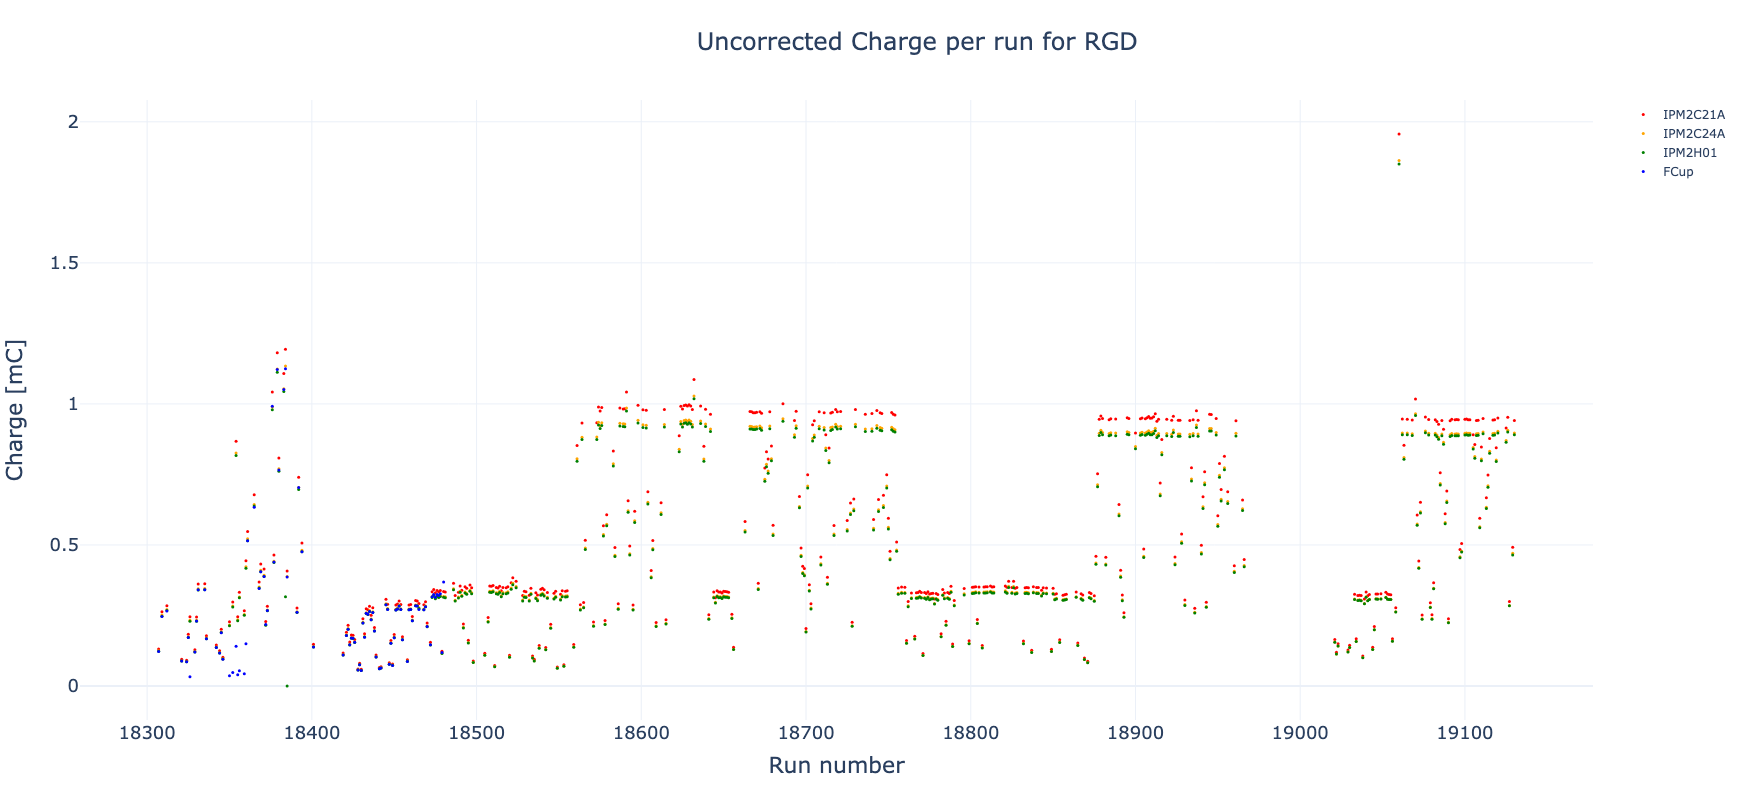

In [10]:
fig = make_subplots() # (specs=[[{"secondary_y": True}]])
fig.update_layout(width=1280, height=800,
                  title=go.layout.Title(text=f"Uncorrected Charge per run for RGD", xanchor="left", x=0.4),
                  titlefont=dict(size=24),)
fig.add_trace(go.Scatter(x=dfx.number, y=dfx.IPM2C21A, mode='markers', name='IPM2C21A', marker=dict(color='red', size=3)), secondary_y=False)
fig.add_trace(go.Scatter(x=dfx.number, y=dfx.IPM2C24A, mode='markers', name='IPM2C24A', marker=dict(color='orange', size=3)), secondary_y=False)
fig.add_trace(go.Scatter(x=dfx.number, y=dfx.IPM2H01, mode='markers', name='IPM2H01', marker=dict(color='green', size=3)), secondary_y=False)
fig.add_trace(go.Scatter(x=dfx.loc[dfx.start_time<start_fcup_trouble,"number"], y=dfx.loc[dfx.start_time<start_fcup_trouble,"scaler_calc1b"], mode='markers', name='FCup', marker=dict(color='blue', size=3)), secondary_y=False)



fig.update_xaxes(title_text="Run number", titlefont=dict(size=22), tickfont=dict(size=18), tickformat="%5d")
fig.update_yaxes(title_text="Charge [mC]", titlefont=dict(size=22), tickfont=dict(size=18))
fig.show()

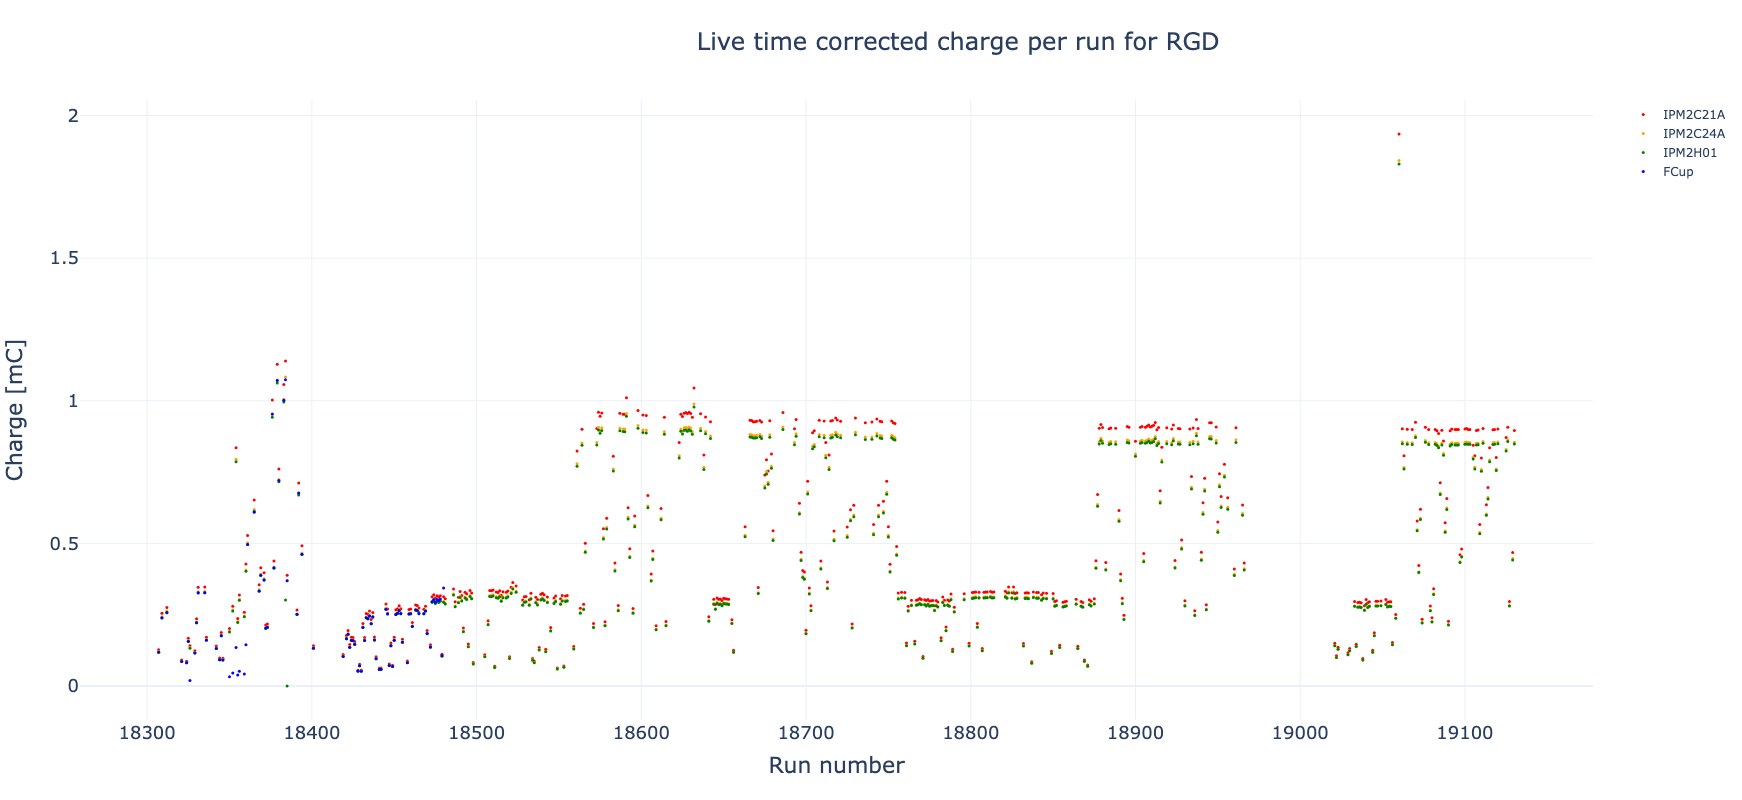

In [13]:
fig = make_subplots() # (specs=[[{"secondary_y": True}]])
fig.update_layout(width=1280, height=800,
                  title=go.layout.Title(text=f"Live time corrected charge per run for RGD", xanchor="left", x=0.4),
                  titlefont=dict(size=24),)
fig.add_trace(go.Scatter(x=dfx.number, y=dfx.IPM2C21A_corr, mode='markers', name='IPM2C21A', marker=dict(color='red', size=3)), secondary_y=False)
fig.add_trace(go.Scatter(x=dfx.number, y=dfx.IPM2C24A_corr, mode='markers', name='IPM2C24A', marker=dict(color='orange', size=3)), secondary_y=False)
fig.add_trace(go.Scatter(x=dfx.number, y=dfx.IPM2H01_corr, mode='markers', name='IPM2H01', marker=dict(color='green', size=3)), secondary_y=False)
fig.add_trace(go.Scatter(x=dfx.loc[dfx.start_time<start_fcup_trouble,"number"], y=dfx.loc[dfx.start_time<start_fcup_trouble,"scaler_calc1b_corr"], mode='markers', name='FCup', marker=dict(color='blue', size=3)), secondary_y=False)



fig.update_xaxes(title_text="Run number", titlefont=dict(size=22), tickfont=dict(size=18), tickformat="%5d")
fig.update_yaxes(title_text="Charge [mC]", titlefont=dict(size=22), tickfont=dict(size=18))
fig.write_image("RGD_LT_corrected_charge_per_run.pdf", width=1200, height=900)
fig.show()

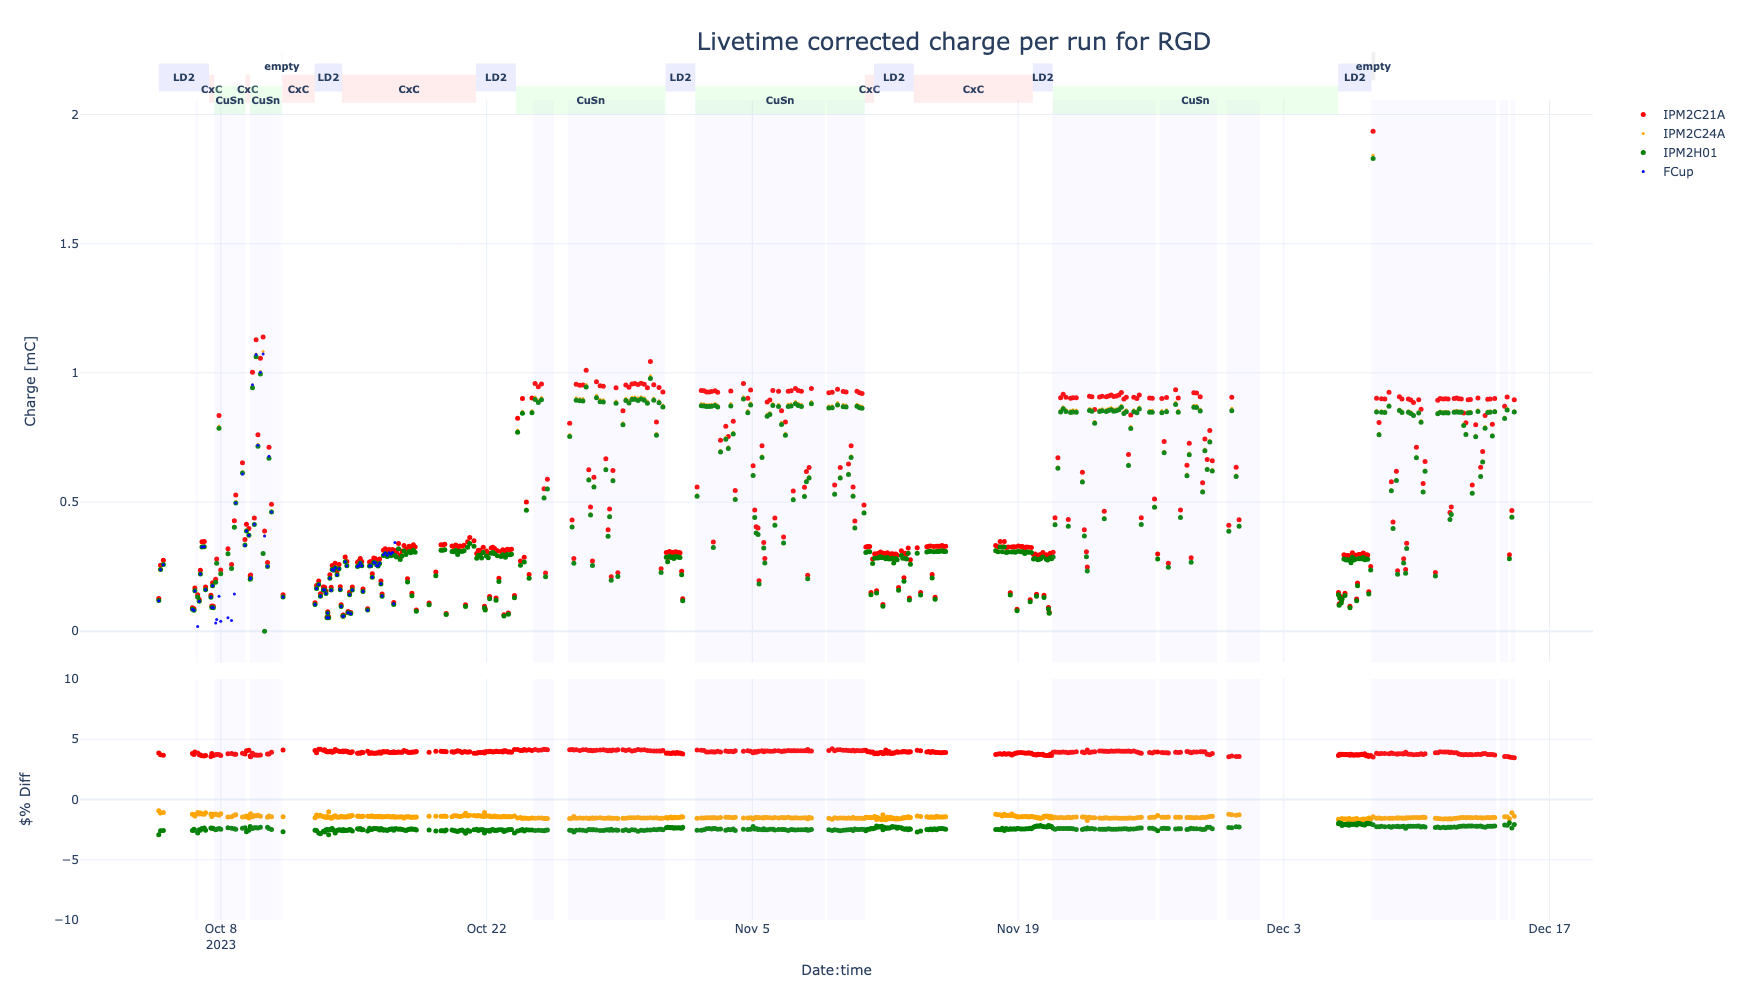

In [92]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,
                    vertical_spacing=0.02, row_heights=[0.7,0.3]) # (specs=[[{"secondary_y": True}]])
fig.update_layout(width=1280, height=1000,
                  title=go.layout.Title(text=f"Livetime corrected charge per run for RGD", xanchor="left", x=0.4),
                  titlefont=dict(size=24),)

fig.add_trace(go.Scatter(x=dfx.time, y=dfx.IPM2C21A_corr, mode='markers', name='IPM2C21A', marker=dict(color='red', size=5)), secondary_y=False)
fig.add_trace(go.Scatter(x=dfx.time, y=dfx.IPM2C24A_corr, mode='markers', name='IPM2C24A', marker=dict(color='orange', size=3)), secondary_y=False)
fig.add_trace(go.Scatter(x=dfx.time, y=dfx.IPM2H01_corr, mode='markers', name='IPM2H01', marker=dict(color='green', size=5)), secondary_y=False)
fig.add_trace(go.Scatter(x=dfx.loc[dfx.start_time<start_fcup_trouble,"time"], y=dfx.loc[dfx.start_time<start_fcup_trouble,"scaler_calc1b_corr"], mode='markers', name='FCup', marker=dict(color='blue', size=3)), secondary_y=False)

fig.add_trace(go.Scatter(x=dfx.time, y=(100*(dfx.IPM2C21A_corr-dfx.ch_mean)/dfx.ch_mean), mode='markers', name='IPM2C21A', showlegend=False, marker=dict(color='red', size=5)), row=2, col=1)
fig.add_trace(go.Scatter(x=dfx.time, y=(100*(dfx.IPM2C24A_corr-dfx.ch_mean)/dfx.ch_mean), mode='markers', name='IPM2C24A', showlegend=False, marker=dict(color='orange', size=5)), row=2, col=1)
fig.add_trace(go.Scatter(x=dfx.time, y=(100*(dfx.IPM2H01_corr-dfx.ch_mean)/dfx.ch_mean), mode='markers', name='IPM2H01', showlegend=False, marker=dict(color='green', size=5)), row=2, col=1)


for i in range(len(beam_stop_in_start)):
     fig.add_vrect(x0=beam_stop_in_start[i],x1=beam_stop_in_end[i], fillcolor="#C0C0FF", opacity=0.1, line_width=0)

target_labels={'empty':(1.06,"#B0B0B0"),'LD2':(1.04,"#A0A0FF"),'CxC':(1.02,"#FFA0A0"),'CuSn':(1.,"#A0FFA0")}
        
for i in range(len(target_change_table)-1):
    time0 = max(target_change_table.iloc[i].name, dfx.iloc[0].time)
    time1 = min(target_change_table.iloc[i+1].name, dfx.iloc[-1].time) 
    target = target_change_table.iloc[i].target
    if time1 > dfx.iloc[0].time and time0 < dfx.iloc[-1].time:
        y_pos = target_labels[target][0]
        fig.add_vrect(x0=time0, x1=time1, xref="x", y0=y_pos-0.025, y1=y_pos+0.025, yref='paper', fillcolor=target_labels[target][1], opacity=0.2, line_width=0, row=1, col=1,
                     label=dict(text="<b>"+target+"</b>", font=dict(size=10)))
        
        
fig.update_xaxes(title_text="Date:time", row=2, col=1)
fig.update_yaxes(title_text="Charge [mC]", row=1, col=1)
fig.update_yaxes(title_text="$% Diff", range=[-10., 10. ], row=2, col=1)
fig.write_image("RGD_LT_corrected_charge_per_run.pdf", width=1200, height=600)
fig.show()

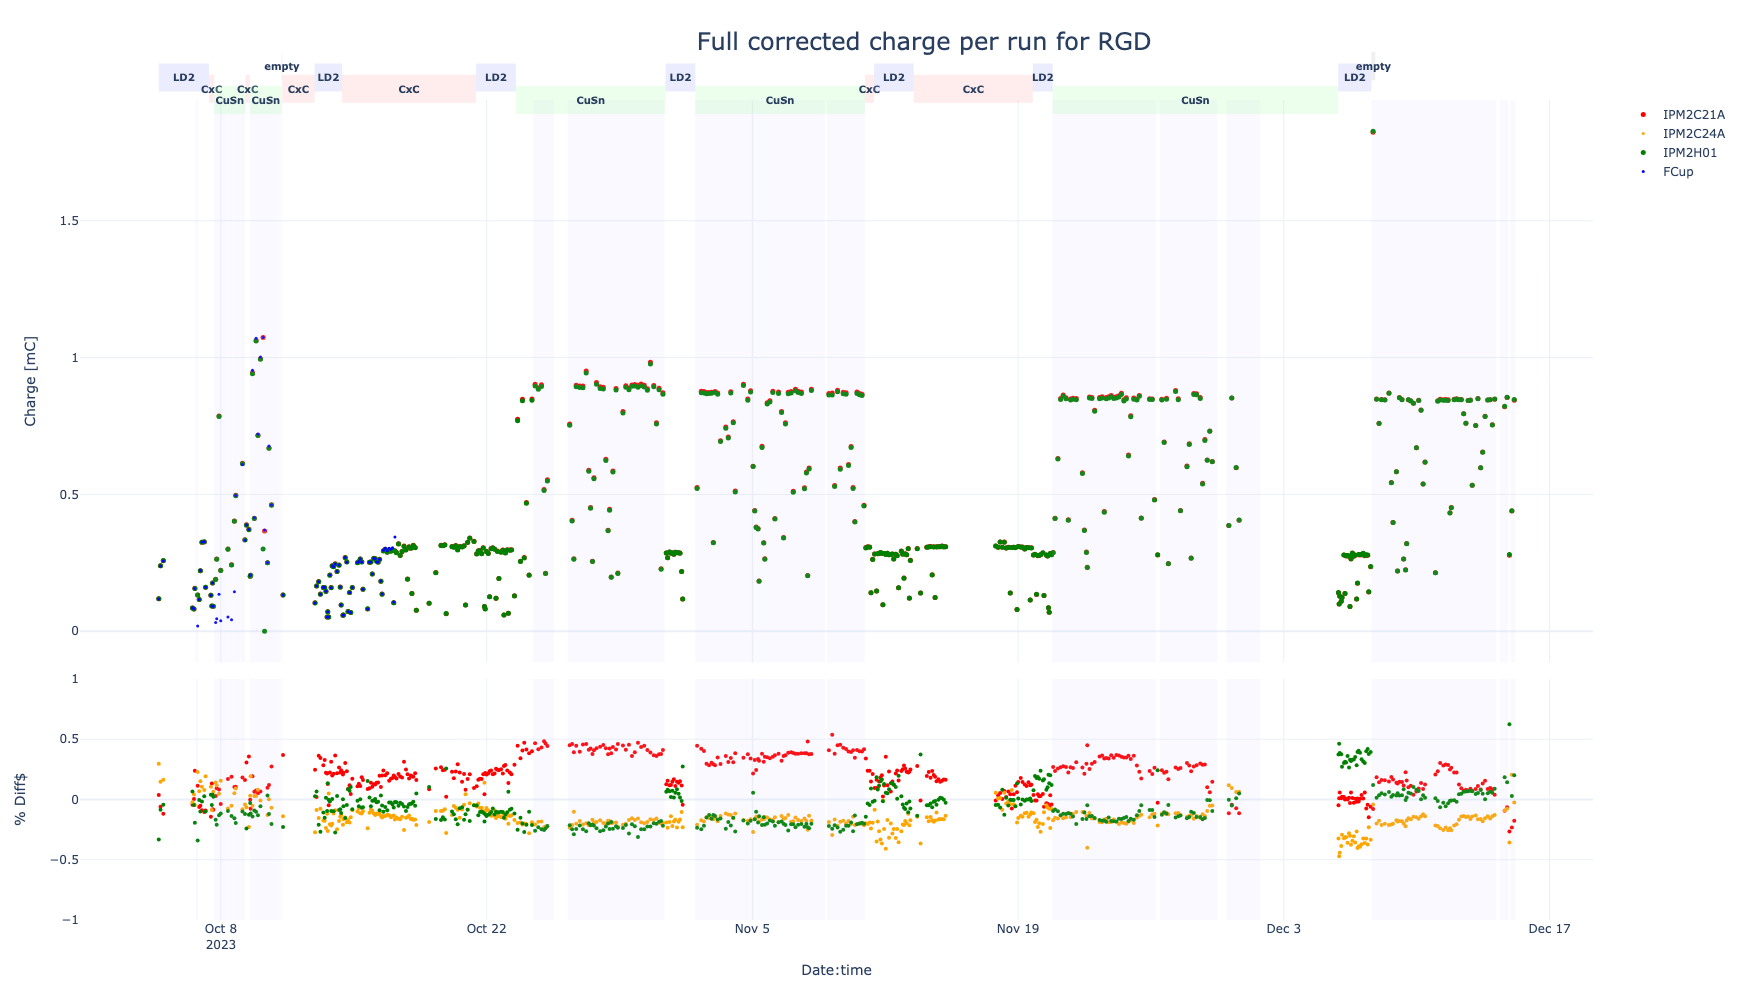

In [90]:
df.loc[:,"ch_mean2"] = np.mean(df.loc[:,['IPM2C21A_corr2','IPM2C24A_corr2','IPM2H01_corr2']],axis=1)
dfx = df[df.event_count >= 20e6]

fig = make_subplots(rows=2, cols=1,shared_xaxes=True,
                    vertical_spacing=0.02, row_heights=[0.7,0.3]) # (specs=[[{"secondary_y": True}]])
fig.update_layout(width=1280, height=1000,
                  title=go.layout.Title(text=f"Full corrected charge per run for RGD", xanchor="left", x=0.4),
                  titlefont=dict(size=24),)

fig.add_trace(go.Scatter(x=dfx.time, y=dfx.IPM2C21A_corr2, mode='markers', name='IPM2C21A', marker=dict(color='red', size=5)), secondary_y=False)
fig.add_trace(go.Scatter(x=dfx.time, y=dfx.IPM2C24A_corr2, mode='markers', name='IPM2C24A', marker=dict(color='orange', size=3)), secondary_y=False)
fig.add_trace(go.Scatter(x=dfx.time, y=dfx.IPM2H01_corr2, mode='markers', name='IPM2H01', marker=dict(color='green', size=5)), secondary_y=False)
fig.add_trace(go.Scatter(x=dfx.loc[dfx.start_time<start_fcup_trouble,"time"], y=dfx.loc[dfx.start_time<start_fcup_trouble,"scaler_calc1b_corr"], mode='markers', name='FCup', marker=dict(color='blue', size=3)), secondary_y=False)

fig.add_trace(go.Scatter(x=dfx.time, y=(100*(dfx.IPM2C21A_corr2-dfx.ch_mean2)/dfx.ch_mean2), mode='markers', name='IPM2C21A', showlegend=False, marker=dict(color='red', size=4)), row=2, col=1)
fig.add_trace(go.Scatter(x=dfx.time, y=(100*(dfx.IPM2C24A_corr2-dfx.ch_mean2)/dfx.ch_mean2), mode='markers', name='IPM2C24A', showlegend=False, marker=dict(color='orange', size=4)), row=2, col=1)
fig.add_trace(go.Scatter(x=dfx.time, y=(100*(dfx.IPM2H01_corr2-dfx.ch_mean2)/dfx.ch_mean2), mode='markers', name='IPM2H01', showlegend=False, marker=dict(color='green', size=4)), row=2, col=1)


for i in range(len(beam_stop_in_start)):
     fig.add_vrect(x0=beam_stop_in_start[i],x1=beam_stop_in_end[i], fillcolor="#C0C0FF", opacity=0.1, line_width=0)

target_labels={'empty':(1.06,"#B0B0B0"),'LD2':(1.04,"#A0A0FF"),'CxC':(1.02,"#FFA0A0"),'CuSn':(1.,"#A0FFA0")}
        
for i in range(len(target_change_table)-1):
    time0 = max(target_change_table.iloc[i].name, dfx.iloc[0].time)
    time1 = min(target_change_table.iloc[i+1].name, dfx.iloc[-1].time) 
    target = target_change_table.iloc[i].target
    if time1 > dfx.iloc[0].time and time0 < dfx.iloc[-1].time:
        y_pos = target_labels[target][0]
        fig.add_vrect(x0=time0, x1=time1, xref="x", y0=y_pos-0.025, y1=y_pos+0.025, yref='paper', fillcolor=target_labels[target][1], opacity=0.2, line_width=0, row=1, col=1,
                     label=dict(text="<b>"+target+"</b>", font=dict(size=10)))
        
        
fig.update_xaxes(title_text="Date:time", row=2, col=1)
fig.update_yaxes(title_text="Charge [mC]", row=1, col=1)
fig.update_yaxes(title_text="% Diff$", range=[-1., 1. ], row=2, col=1)
fig.write_image("RGD_Full_corrected_charge_per_run.pdf", width=1200, height=600)
fig.show()

In [29]:
# Get the corrected data from the HDF5 file.
# In this data, the corrections are already applied in the RGD_currents.ipynb notebook.
store = HDFStore("RGD_mya_data_corr.h5")
current_IPM2C21A = store['IPM2C21A']
current_IPM2C24A = store['IPM2C24A']
current_IPM2H01 = store['IPM2H01']
current_scalerS2b = store['scalerS2b']
current_FCup = store['scaler_calc1b']
LT_DAQ = store['DAQ_livetime']
LT_Trigger = store['Trigger_livetime']
LT_clock = store['Pulser_livetime']
store.close()
# Drop the invalid entries:
data_list = [(current_IPM2C21A,'IPM2C21A'),(current_IPM2C24A,'IPM2C24A'), (current_IPM2H01,'IPM2H01'),
             (current_scalerS2b,'scalerS2b'), (current_FCup,'FCup'), (LT_DAQ,'LT_DAQ'), (LT_Trigger,'LT_Trigger'), (LT_clock,'LT_clock')]
for dat in data_list:
    data = dat[0]
    if np.any(np.isnan(data.value)):
        data.drop(data.loc[np.isnan(data.value)].index,inplace=True)

In [30]:
if 'time' in LT_DAQ.keys():
    LT_DAQ.set_index('time',inplace=True)
    
for idx in df.index:
    # For each run in the table, get the start and end time.
    start_time = df.loc[idx].start_time
    end_time = df.loc[idx].end_time
    for dat in data_list[0:3]:
        data = dat[0]
        name = dat[1]
        selector = (data.time >= start_time)&(data.time <= end_time)
        # Get an indexer into the LT_DAQ for this timespan.
        indexer = LT_DAQ.index.get_indexer(data.loc[selector].time,method='ffill')
        LT_Correction1 = LT_DAQ.iloc[indexer]
        # ALSO get an interpolated LT_DAQ at the correct times.
        # LT_Correction2 = np.interp(data.loc[selector].time,  LT_DAQ.index, LT_DAQ.value)
        # Compute the difference over sum error estimate.
        # error = np.sum(LT_Correction1.value - LT_Correction2)**2/len(LT_Correction1.value)
        # print(idx, len(data.loc[selector]), error, np.sum(LT_Correction1.value - LT_Correction2)**2)
        corrected_current = data.loc[selector,"corr"].to_numpy()*LT_Correction1.value.to_numpy()/100
        #corrected_current2 = data.loc[selector].value.to_numpy()*LT_Correction2/100
        #print(len(corrected_current), len(data.loc[selector]))
        charge_total = np.trapz(corrected_current, data.loc[selector].ms)*1e-9
        df.loc[idx,name+"_corr3"] = charge_total
        #charge_total2 = np.trapz(corrected_current2, data.loc[selector].ms)*1e-9
        #print(charge_total, charge_total2, dfx.loc[idx,"IPM2C21A_corr2"])

In [37]:
# Fixup the problem runs where IPM2H01 was not working by setting IPM2H01 to None instead of 0
df.loc[df.IPM2H01<0.001,'IPM2H01_corr3'] = None
# Set the "charge" for each run to the mean of the fully corrected BPM values.
df.loc[:,"charge"] = np.mean(df.loc[:,['IPM2C21A_corr3','IPM2C24A_corr3','IPM2H01_corr3']],axis=1)
dfx = df[df.event_count >= 20e6]

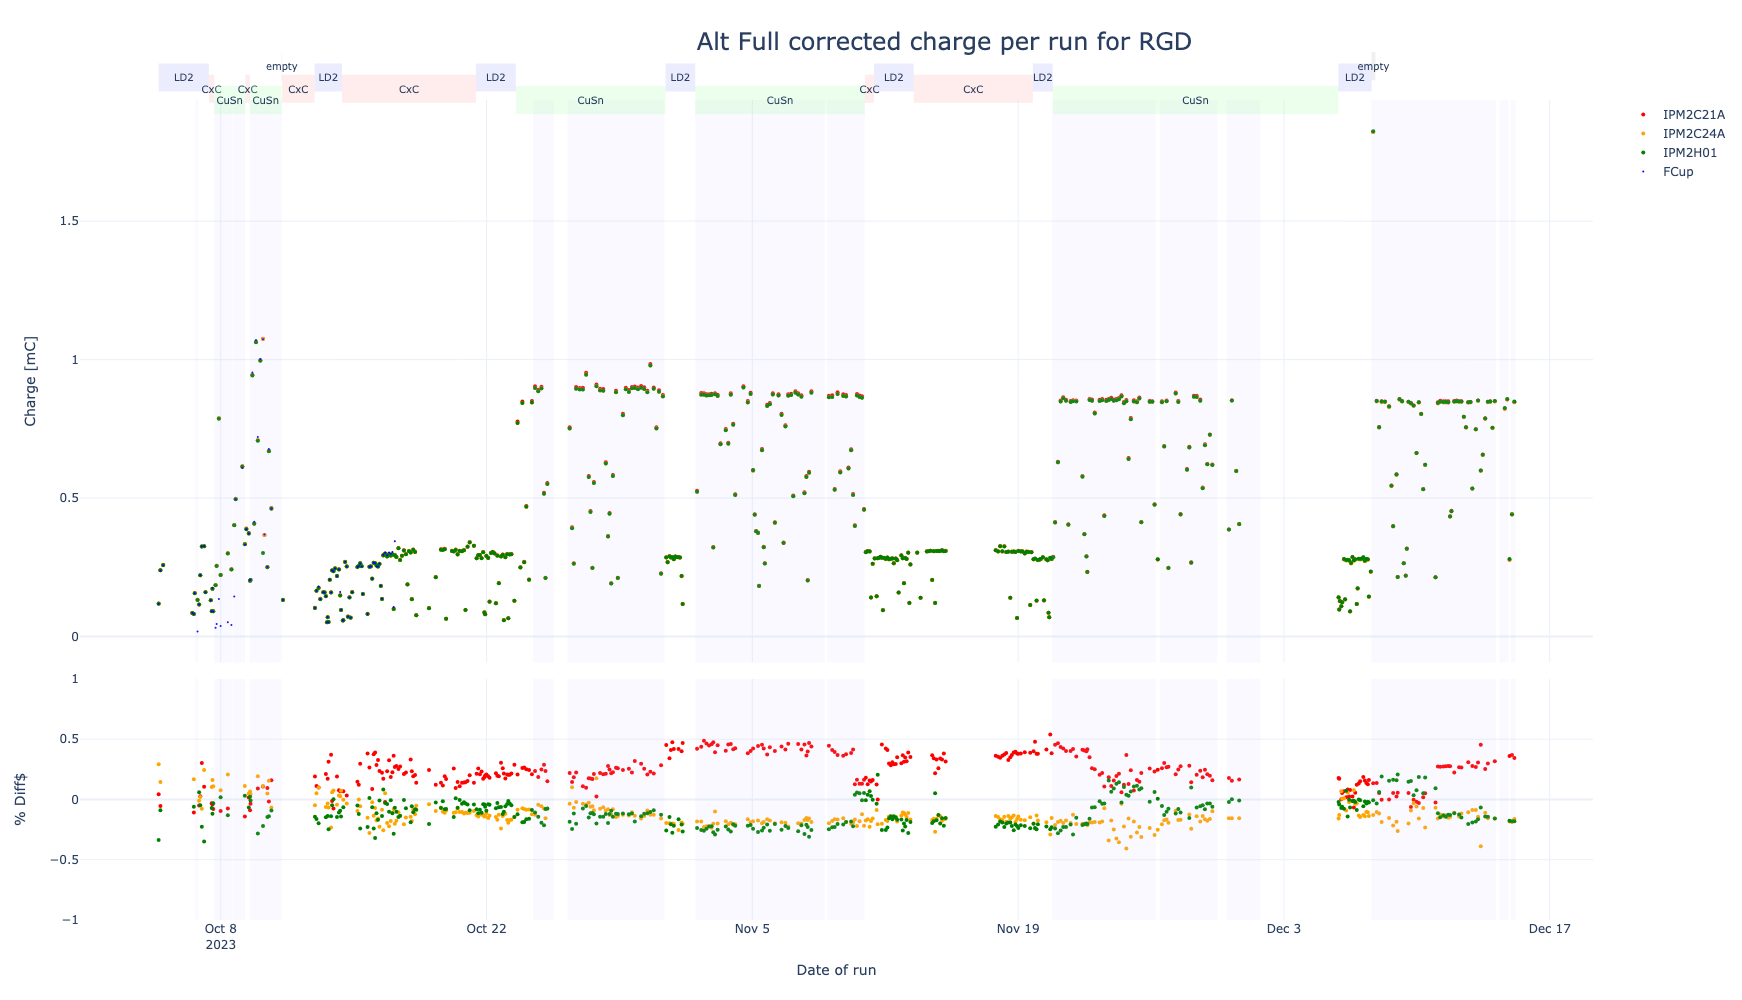

In [53]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,
                    vertical_spacing=0.02, row_heights=[0.7,0.3]) # (specs=[[{"secondary_y": True}]])
fig.update_layout(width=1280, height=1000,
                  title=go.layout.Title(text=f"Alt Full corrected charge per run for RGD", xanchor="left", x=0.4),
                  titlefont=dict(size=24),)
x_scale = dfx.time
fig.add_trace(go.Scatter(x=x_scale, y=dfx.IPM2C21A_corr3, mode='markers', name='IPM2C21A', marker=dict(color='red', size=4)), row=1, col=1)
fig.add_trace(go.Scatter(x=x_scale, y=dfx.IPM2C24A_corr3, mode='markers', name='IPM2C24A', marker=dict(color='orange', size=4)), row=1, col=1)
fig.add_trace(go.Scatter(x=x_scale, y=dfx.IPM2H01_corr3, mode='markers', name='IPM2H01', marker=dict(color='green', size=4)), row=1, col=1)
fig.add_trace(go.Scatter(x=x_scale, y=dfx.loc[dfx.start_time<start_fcup_trouble,"scaler_calc1b_corr"], mode='markers', name='FCup', marker=dict(color='blue', size=2)), row=1, col=1)
# dfx.loc[dfx.start_time<start_fcup_trouble,"time"]                         
fig.add_trace(go.Scatter(x=x_scale, y=(100*(dfx.IPM2C21A_corr3-dfx.charge)/df.charge), mode='markers', name='IPM2C21A', showlegend=False, marker=dict(color='red', size=4)), row=2, col=1)
fig.add_trace(go.Scatter(x=x_scale, y=(100*(dfx.IPM2C24A_corr3-dfx.charge)/df.charge), mode='markers', name='IPM2C24A', showlegend=False, marker=dict(color='orange', size=4)), row=2, col=1)
fig.add_trace(go.Scatter(x=x_scale, y=(100*(dfx.IPM2H01_corr3-dfx.charge)/df.charge), mode='markers', name='IPM2H01', showlegend=False, marker=dict(color='green', size=4)), row=2, col=1)

for i in range(len(beam_stop_in_start)):
     fig.add_vrect(x0=beam_stop_in_start[i],x1=beam_stop_in_end[i], fillcolor="#C0C0FF", opacity=0.1, line_width=0)

target_labels={'empty':(1.06,"#B0B0B0"),'LD2':(1.04,"#A0A0FF"),'CxC':(1.02,"#FFA0A0"),'CuSn':(1.,"#A0FFA0")}
        
for i in range(len(target_change_table)-1):
    time0 = max(target_change_table.iloc[i].name, dfx.iloc[0].time)
    time1 = min(target_change_table.iloc[i+1].name, dfx.iloc[-1].time) 
    target = target_change_table.iloc[i].target
    if time1 > dfx.iloc[0].time and time0 < dfx.iloc[-1].time:
        y_pos = target_labels[target][0]
        fig.add_vrect(x0=time0, x1=time1, xref="x", y0=y_pos-0.025, y1=y_pos+0.025, yref='paper', fillcolor=target_labels[target][1], opacity=0.2, line_width=0, row=1, col=1,
                     label=dict(text=target, font=dict(size=10)))

fig.update_xaxes(title_text="Date of run", row=2, col=1)
fig.update_yaxes(title_text="Charge [mC]", row=1, col=1)
fig.update_yaxes(title_text="% Diff$", range=[-1., 1. ], row=2, col=1)
#fig.update_yaxes(title_text="", titlefont=dict(size=22), tickfont=dict(size=18))
fig.write_image("RGD_Full_corrected_charge_per_run2.pdf",width=1200, height=600)
fig.show()

In [40]:
import ROOT as R

In [89]:
numpy_dat1 = (100*(dfx.IPM2C21A_corr3-dfx.charge)/dfx.charge).to_numpy()
hist1 = R.TH1D("diff_hist1","% deviation from average;\Delta percent",100,-1.,1.)
hist1.FillN(numpy_dat1.size, numpy_dat1, np.ones(numpy_dat1.size))

numpy_dat2 = (100*(dfx.IPM2C24A_corr3-dfx.charge)/dfx.charge).to_numpy()
hist2 = R.TH1D("diff_hist1","% deviation from average;\Delta percent",100,-1.,1.)
hist2.FillN(numpy_dat2.size, numpy_dat2, np.ones(numpy_dat2.size))

numpy_dat3 = (100*(dfx.IPM2H01_corr3-dfx.charge)/dfx.charge).to_numpy()
hist3 = R.TH1D("diff_hist1","% deviation from average;\Delta percent",100,-1.,1.)
hist3.FillN(numpy_dat3.size, numpy_dat3, np.ones(numpy_dat3.size))

cc = R.TCanvas("cc","cc",800,600)
hist2.SetStats(0)
hist2.SetLineWidth(2)
hist2.SetLineColor(R.kOrange)
hist2.Draw()
hist1.SetLineWidth(2)
hist1.SetLineColor(R.kRed)
hist1.Draw("same")
hist2.SetLineColor(R.kOrange)
hist2.Draw("same")
hist3.SetLineWidth(2)
hist3.SetLineColor(R.kGreen)
hist3.Draw("same")
leg = R.TLegend(0.7,0.7,0.89,0.89)
leg.AddEntry(hist1,"2C21A")
leg.AddEntry(hist2,"2C24A")
leg.AddEntry(hist3,"2H01")
leg.Draw()
cc.SaveAs("RGD_Full_corrected_charge_per_run2_diffs.pdf")
cc.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: diff_hist1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: diff_hist1 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc
Info in <TCanvas::Print>: pdf file RGD_Full_corrected_charge_per_run2_diffs.pdf has been created


In [88]:
numpy_dat1a = (100*(dfx.IPM2C21A_corr3-dfx.charge)/dfx.charge).to_numpy()
hist1a = R.TH1D("diff_hist1a","% deviation from average;\Delta percent",100,-1.,1.)
hist1a.FillN(110, numpy_dat1[0:110], np.ones(110))

# numpy_dat2 = (100*(dfx.IPM2C24A_corr3-dfx.charge)/dfx.charge).to_numpy()
hist2a = R.TH1D("diff_hist2a","% deviation from average;\Delta percent",100,-1.,1.)
hist2a.FillN(110, numpy_dat2[0:110], np.ones(110))

# numpy_dat3 = (100*(dfx.IPM2H01_corr3-dfx.charge)/dfx.charge).to_numpy()
hist3a = R.TH1D("diff_hist3a","% deviation from average;\Delta percent",100,-1.,1.)
hist3a.FillN(110, numpy_dat3[0:110], np.ones(110))

# numpy_dat1a = (100*(dfx.IPM2C21A_corr3-dfx.charge)/dfx.charge).to_numpy()
hist1b = R.TH1D("diff_hist1b","% deviation from average;\Delta percent",100,-1.,1.)
hist1b.FillN(265, numpy_dat1[110:375], np.ones(265))

# numpy_dat2 = (100*(dfx.IPM2C24A_corr3-dfx.charge)/dfx.charge).to_numpy()
hist2b = R.TH1D("diff_hist2b","% deviation from average;\Delta percent",100,-1.,1.)
hist2b.FillN(265, numpy_dat2[110:375], np.ones(265))

# numpy_dat3 = (100*(dfx.IPM2H01_corr3-dfx.charge)/dfx.charge).to_numpy()
hist3b = R.TH1D("diff_hist3b","% deviation from average;\Delta percent",100,-1.,1.)
hist3b.FillN(265, numpy_dat3[110:375], np.ones(265))

# numpy_dat1a = (100*(dfx.IPM2C21A_corr3-dfx.charge)/dfx.charge).to_numpy()
hist1c = R.TH1D("diff_hist1c","% deviation from average;\Delta percent",100,-1.,1.)
hist1c.FillN(112, numpy_dat1[375:], np.ones(337))

# numpy_dat2 = (100*(dfx.IPM2C24A_corr3-dfx.charge)/dfx.charge).to_numpy()
hist2c = R.TH1D("diff_hist2c","% deviation from average;\Delta percent",100,-1.,1.)
hist2c.FillN(112, numpy_dat2[375:], np.ones(337))

# numpy_dat3 = (100*(dfx.IPM2H01_corr3-dfx.charge)/dfx.charge).to_numpy()
hist3c = R.TH1D("diff_hist3c","% deviation from average;\Delta percent",100,-1.,1.)
hist3c.FillN(112, numpy_dat3[375:], np.ones(337))


cc2 = R.TCanvas("cc2","cc2",800,600)
hist2a.SetStats(0)
hist2a.SetLineWidth(2)
hist2a.SetLineColor(R.kOrange)
hist2a.Draw()
hist1a.SetLineWidth(2)
hist1a.SetLineColor(R.kRed)
hist1a.Draw("same")
hist2a.SetLineColor(R.kOrange)
hist2a.Draw("same")
hist3a.SetLineWidth(2)
hist3a.SetLineColor(R.kGreen)
hist3a.Draw("same")

# hist2b.SetStats(0)
# hist2b.SetLineWidth(2)
# hist2b.SetLineColor(R.kOrange+1)
# hist2b.Draw("same")
# hist1b.SetLineWidth(2)
# hist1b.SetLineColor(R.kRed+1)
# hist1b.Draw("same")
# hist2b.SetLineColor(R.kOrange+1)
# hist2b.Draw("same")
# hist3b.SetLineWidth(2)
# hist3b.SetLineColor(R.kGreen+1)
# hist3b.Draw("same")

hist2c.SetStats(0)
hist2c.SetLineWidth(2)
hist2c.SetLineColor(R.kOrange+2)
hist2c.Draw("same")
hist1c.SetLineWidth(2)
hist1c.SetLineColor(R.kRed+2)
hist1c.Draw("same")
hist2c.SetLineColor(R.kOrange+2)
hist2c.Draw("same")
hist3c.SetLineWidth(2)
hist3c.SetLineColor(R.kGreen+2)
hist3c.Draw("same")
leg = R.TLegend(0.7,0.7,0.89,0.89)
leg.AddEntry(hist1a,"2C21A")
leg.AddEntry(hist2a,"2C24A")
leg.AddEntry(hist3a,"2H01")
leg.Draw()
cc2.SaveAs("RGD_Full_corrected_charge_per_run2_diffs_split.pdf")
cc2.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: diff_hist1a (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: diff_hist2a (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: diff_hist3a (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: diff_hist1b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: diff_hist2b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: diff_hist3b (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: diff_hist1c (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: diff_hist2c (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: diff_hist3c (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc2
Info in <TCanvas::Print>: pdf file RGD_Full_corrected_charge_per_run2_diffs_split.pdf has been created


In [93]:
write_out_columns=['number', 'start_time', 'end_time', 'run_start_time',
       'run_end_time', 'is_valid_run_end', 'run_type',
       'target', 'beam_current_request', 'event_count', 'events_rate',
       'run_config', 'evio_files_count', 'megabyte_count', 'charge', 'B_DAQ:livetime', 'IPM2C21A', 'IPM2C21A_corr', 
       'IPM2C24A', 'IPM2C24A_corr', 'IPM2H01', 'IPM2H01_corr', 'scaler_calc1b',
       'scaler_calc1b_corr', 'center', 'dt', 'event_rate', 'time', 'IPM2C21A_corr2', 'IPM2C24A_corr2',
       'IPM2H01_corr2', 'IPM2C21A_corr3', 'IPM2C24A_corr3', 'IPM2H01_corr3','operators',
       'user_comment']
df.to_excel("RGD_all_runs_fully_corrected_all_corrections.xlsx",columns=write_out_columns)

In [96]:
write_out_columns=['number', 'start_time', 'end_time', 'dt', 'run_type',
       'target', 'beam_current_request', 'event_count', 'events_rate',
       'run_config', 'evio_files_count', 'megabyte_count', 'B_DAQ:livetime','charge', 'IPM2C21A', 
       'IPM2C24A','IPM2H01', 'IPM2C21A_corr3', 'IPM2C24A_corr3', 'IPM2H01_corr3','operators',
       'user_comment']
df.to_excel("RGD_all_runs_fully_corrected.xlsx",columns=write_out_columns)

In [97]:
df.loc[:,write_out_columns]

,number,start_time,end_time,dt,run_type,target,beam_current_request,event_count,events_rate,run_config,...,B_DAQ:livetime,charge,IPM2C21A,IPM2C24A,IPM2H01,IPM2C21A_corr3,IPM2C24A_corr3,IPM2H01_corr3,operators,user_comment
0,18307,2023-10-04 16:48:06,2023-10-04 18:08:10,4799196,PROD66_PIN,LD2,35nA,34887485,1471.580,rgd_v1.0_no_DC.cnf,...,4.666289e+08,0.119186,0.131464,0.125393,0.122872,0.119239,0.119534,0.118787,"expert: Xiangdong Wei, worker: Simone Vallarino",trigger velidation
1,18309,2023-10-04 18:35:15,2023-10-04 20:47:26,7923069,PROD66_PIN,LD2,35nA,70064834,1837.890,rgd_v1.0_no_DC.cnf,...,7.680122e+08,0.239848,0.263602,0.251334,0.247574,0.239717,0.240196,0.239631,"expert: Xiangdong Wei, worker: Simone Vallarino","production with DC at 10,10,10"
2,18310,2023-10-04 20:51:48,2023-10-04 21:19:53,1683315,PROD66_PIN,LD2,35nA,12088751,913.765,rgd_v1.0_no_DC.cnf,...,1.626712e+08,0.041813,0.046154,0.044074,0.043120,0.041830,0.041974,0.041635,"expert: Xiangdong Wei, worker: Simone Vallarino","production with DV at 9,9,9"
3,18311,2023-10-04 21:23:49,2023-10-04 21:53:59,1808190,PROD66_PIN,LD2,35nA,13847054,1998.350,rgd_v1.0_no_DC.cnf,...,1.746395e+08,0.048020,0.052969,0.050461,0.049547,0.048066,0.048117,0.047877,"expert: Xiangdong Wei, worker: Simone Vallarino","production with DC at 11,12,12"
4,18312,2023-10-04 21:58:51,2023-10-05 00:26:42,8862129,PROD66_PIN,LD2,35nA,75489190,521.412,rgd_v1.0_no_DC.cnf,...,8.599570e+08,0.259043,0.284501,0.271432,0.267397,0.258765,0.259476,0.258889,"expert: Xiangdong Wei, worker: Simone Vallarino","production with DC at 10,11,11"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,19126,2023-12-14 16:53:51,2023-12-14 19:42:30,10108881,PROD67,CuSn,100 nA,100008986,398.642,rgd_out_v2.3_Q2_1.2.cnf,...,9.509407e+08,0.856908,0.952746,0.906611,0.900308,0.856371,0.856276,0.858077,"expert: Gerard Gilfoyle, worker: John Price",production
631,19127,2023-12-14 19:48:20,2023-12-14 22:34:19,9949041,PROD67,CuSn,30 nA,30011094,2018.170,rgd_out_v2.3_Q2_1.2.cnf,...,9.828894e+08,0.278421,0.299909,0.285097,0.284098,0.277693,0.277418,0.280152,"expert: Gerard Gilfoyle, worker: John Price",Low Lumi run
632,19128,2023-12-14 22:41:21,2023-12-14 22:50:52,570429,PROD67,CuSn,100 nA,6053694,1603.420,rgd_out_v2.3_Q2_1.2.cnf,...,5.241314e+07,0.050363,0.056574,0.053879,0.053490,0.050343,0.050284,0.050461,"expert: Gerard Gilfoyle, worker: John Price/ ...","Production, return to full current"
633,19129,2023-12-14 22:55:22,2023-12-15 01:46:08,10235754,PROD67,CuSn,100 nA,51643579,1208.500,rgd_out_v2.3_Q2_1.2.cnf,...,9.979474e+08,0.441536,0.492264,0.470429,0.464486,0.440534,0.442439,0.441636,"expert: Gerard Gilfoyle, worker: John Price",production with 90 min down time
